<a href="https://colab.research.google.com/github/Juanchoalric/animal_detector/blob/main/animal_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

In [3]:
from google.colab import userdata
KAGGLE_API_TOKEN = userdata.get('KAGGLE_API_TOKEN')

In [4]:
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: juancruzalric
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 188MB/s] 


In [5]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, dataloader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
image_path = []
labels = []
datasets_type = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)
      datasets_type.append(i)

In [8]:
df = pd.DataFrame(zip(image_path, datasets_type, labels), columns=["image_path", "datasets_type", "labels"])

In [9]:
df.head()

,image_path,datasets_type,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,train,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,train,cat
2,/content/animal-faces/afhq/train/cat/flickr_ca...,train,cat
3,/content/animal-faces/afhq/train/cat/flickr_ca...,train,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,train,cat


In [10]:
train_df = df[df["datasets_type"] == "train"].drop("datasets_type", axis=1)
test_df = df[df["datasets_type"] == "val"].drop("datasets_type", axis=1)

In [11]:
val_df = test_df.sample(frac=0.5)
test_df = test_df.drop(val_df.index)

In [12]:
label_encoder = LabelEncoder()

label_encoder.fit(train_df["labels"])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

In [13]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df["labels"])).to(device)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [14]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)
test_dataset = CustomImageDataset(test_df, transform=transform)

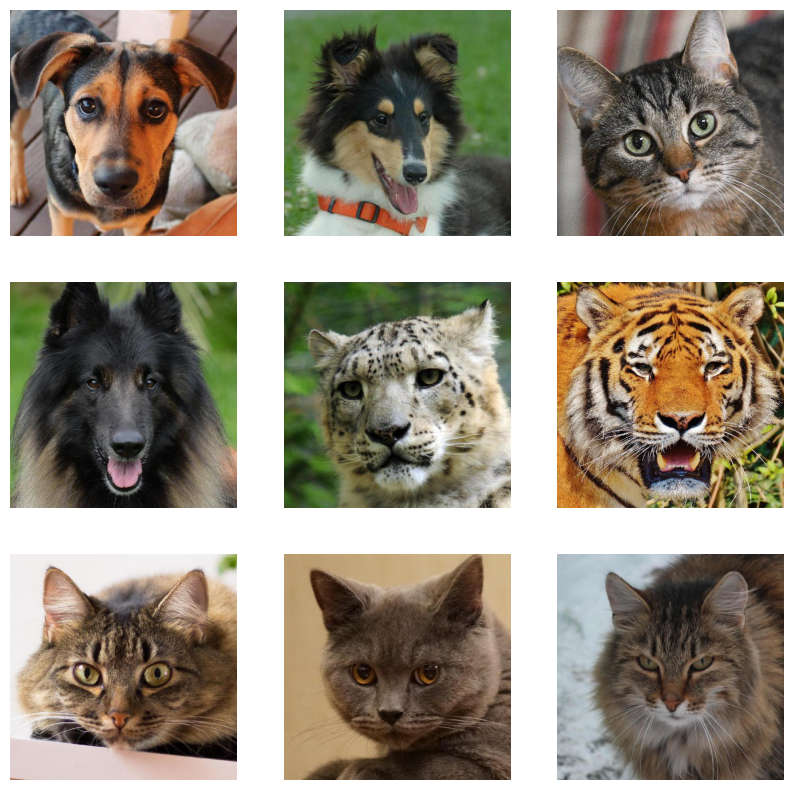

In [15]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()


In [16]:
lr = 1e-4
BATCH_SIZE = 16
EPOCHS = 4

In [17]:
train_loader = dataloader.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dataloader.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(2, 2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128 * 28 * 28, 224)

    self.output = nn.Linear(224, len(label_encoder.classes_))

  def forward(self, x):
    x = self.conv1(x) # -> (32, 224, 224)
    x = self.pool(x) # -> (32, 112, 112)
    x = self.relu(x)

    x = self.conv2(x) # -> (64, 112, 112)
    x = self.pool(x) # -> (64, 56, 56)
    x = self.relu(x)

    x = self.conv3(x) # -> (128, 56, 56)
    x = self.pool(x) # -> (128, 28, 28)
    x = self.relu(x)

    x = self.flatten(x) # -> (128 * 28 * 28)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.output(x)
    return x

In [19]:
model = Net().to(device)

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
         MaxPool2d-5           [-1, 64, 56, 56]               0
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
         MaxPool2d-8          [-1, 128, 28, 28]               0
              ReLU-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 224]      22,479,072
             ReLU-12                  [-1, 224]               0
           Linear-13                    [-1, 3]             675
Total params: 22,572,995
Trainable para

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [22]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  model.train()

  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    predictions = model(inputs)

    train_loss = criterion(predictions, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()
    optimizer.step()

    total_acc_train += (predictions.argmax(dim=1) == labels).sum().item()

  model.eval()
  with torch.inference_mode():
    for inputs, labels in val_loader:
      predictions = model(inputs)

      val_loss = criterion(predictions, labels)

      total_loss_val += val_loss.item()

      total_acc_val += (predictions.argmax(dim=1) == labels).sum().item()

  total_loss_train_plot.append(total_loss_train / len(train_loader))
  total_loss_val_plot.append(total_loss_val / len(val_loader))

  total_acc_train_plot.append(total_acc_train / len(train_dataset))
  total_acc_val_plot.append(total_acc_val / len(val_dataset))

  print(f"Epoch: {epoch+1}")
  print(f"Train loss: {total_loss_train / len(train_loader)}")
  print(f"Val loss: {total_loss_val / len(val_loader)}")
  print(f"Train acc: {total_acc_train / len(train_dataset)}")
  print(f"Val acc: {total_acc_val / len(val_dataset)}")
  print("-"*50)


Epoch: 1
Train loss: 0.42121464663841685
Val loss: 0.22940461488163216
Train acc: 0.8281613123718387
Val acc: 0.9146666666666666
--------------------------------------------------
Epoch: 2
Train loss: 0.17586835815667942
Val loss: 0.15397492962631773
Train acc: 0.9367737525632263
Val acc: 0.9493333333333334
--------------------------------------------------
Epoch: 3
Train loss: 0.10743932181198272
Val loss: 0.1263440621402511
Train acc: 0.9604921394395078
Val acc: 0.952
--------------------------------------------------
Epoch: 4
Train loss: 0.06972059256389554
Val loss: 0.1252641094937683
Train acc: 0.9763499658236501
Val acc: 0.952
--------------------------------------------------


In [24]:
model.eval()
with torch.inference_mode():
  total_acc_test = 0
  total_loss_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

    total_acc_test += (predictions.argmax(dim=1) == labels).sum().item()

  print(f"Test loss: {total_loss_test / len(test_loader)}")
  print(f"Test acc: {total_acc_test / len(test_dataset)}")

Test loss: 0.12642241358766926
Test acc: 0.948


<Figure size 1000x500 with 0 Axes>

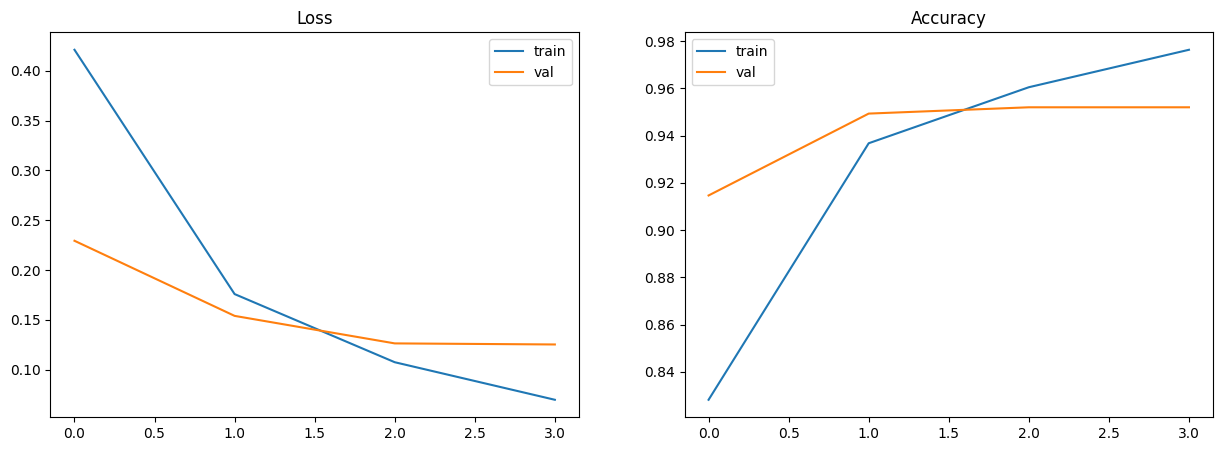

In [34]:
# plot the train and val loss an acc
plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(total_loss_train_plot, label="train")
ax[0].plot(total_loss_val_plot, label="val")
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(total_acc_train_plot, label="train")
ax[1].plot(total_acc_val_plot, label="val")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

In [38]:
def predict_image():
  img = Image.open("/content/download (1).jpeg").convert("RGB")

  image = transform(img).to(device)

  image = image.unsqueeze(0)

  model.eval()
  with torch.inference_mode():
    predictions = model(image)

    print(f"Predicted class: {label_encoder.classes_[predictions.argmax(dim=1)]}")

In [39]:
predict_image()

Predicted class: cat
